<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/DefaultPredictorsAt25Percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Predictors
Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [1]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 923.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.6 MB/s eta 0:00:00


## Fetching Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

In [3]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git


Cloning into 'Volve-Well-Log-Prediction'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 142 (delta 59), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (142/142), 69.29 MiB | 12.81 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [4]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [5]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [6]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [7]:
num_rows_to_drop = int(0.75 * len(train))

# Randomly sample rows to drop
rows_to_drop = train.sample(n=num_rows_to_drop)

# Drop the sampled rows from the DataFrame
train = train.drop(rows_to_drop.index)
train_preserve = train.copy()

In [8]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [9]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.618208,-0.638733,1.201046,-0.430021,0.248582,0.0,1.483511,15_9-F-11A,2600.0
1,0.988796,-1.191107,0.7437,-0.512127,-1.286485,-0.0,1.170465,15_9-F-11A,2600.5
2,1.039596,-1.235743,0.621521,-0.434343,-1.245132,-0.0,1.090476,15_9-F-11A,2600.6
3,1.102782,-1.240668,0.513085,-0.447442,-1.110861,-0.0,0.982555,15_9-F-11A,2600.7
4,1.157016,-1.211015,0.492691,-0.534538,-0.939974,-0.0,0.929501,15_9-F-11A,2600.8


## Outlier Removal

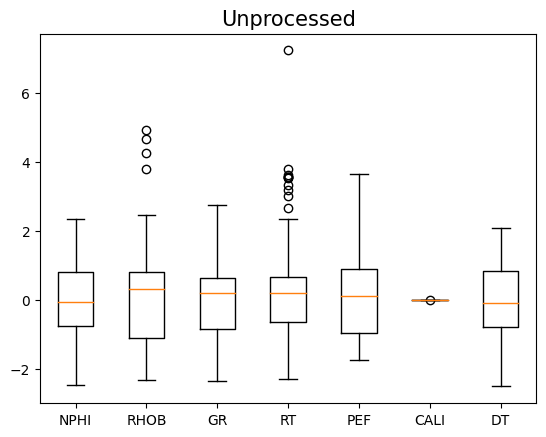

n samples unprocessed: 1318


In [10]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

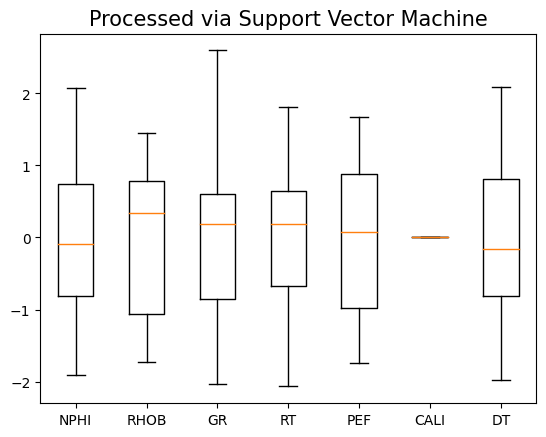

Remaining samples: 1185


In [11]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [12]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [13]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [14]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

### Decison Tree Regressor


In [15]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_decision_tree.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_decision_tree.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


RMSE for Fold 1: 0.3369
RMSE for Fold 2: 0.3413
RMSE for Fold 3: 0.3138
RMSE for Fold 4: 0.3189
RMSE for Fold 5: 0.3025
Average RMSE: 0.3227
R2 Log 1: 0.9569
RMSE Log 1: 0.214
R2 Log 3: 0.9532
RMSE Log 3: 0.1986
R2 Log 4: 0.9433
RMSE Log 4: 0.2077


### Gradient Booster Regressor

In [16]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_grad_boost.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_grad_boost.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 1: 0.2171


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 2: 0.2514


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 3: 0.2454


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 4: 0.2612


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 5: 0.2406
R2 Log 1: 0.9488
RMSE Log 1: 0.2332
R2 Log 3: 0.945
RMSE Log 3: 0.2153
R2 Log 4: 0.9056
RMSE Log 4: 0.268


### Neural Network

In [17]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the neural network model to the training fold
    history_nn = model_nn.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_nn.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


8/8 [==============================] - 0s 5ms/step
RMSE for Fold 1: 0.3296
8/8 [==============================] - 0s 3ms/step
RMSE for Fold 2: 0.2641
8/8 [==============================] - 0s 5ms/step
RMSE for Fold 3: 0.2374
8/8 [==============================] - 0s 4ms/step
RMSE for Fold 4: 0.2373
8/8 [==============================] - 0s 4ms/step
RMSE for Fold 5: 0.2240
Average RMSE: 0.2585
24/24 [==============================] - 0s 3ms/step
RMSE Neural Network Log 1: 0.2782999873161316
17/17 [==============================] - 0s 3ms/step
RMSE Neural Network Log 3: 0.2621000111103058
2/2 [==============================] - 0s 10ms/step
RMSE Neural Network Log 4: 0.2565000057220459


### LSTM

In [18]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train, y_train, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [19]:
y_train_lstm.shape

(1175, 1)

In [20]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train_lstm)):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[val_index]
    y_train_fold, y_val_fold = y_train_lstm[train_index], y_train_lstm[val_index]


    # Fit the bidirectional LSTM model to the training fold
    history = model_lstm.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_lstm.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


8/8 [==============================] - 3s 11ms/step
RMSE for Fold 1: 0.4475
8/8 [==============================] - 0s 11ms/step
RMSE for Fold 2: 0.4524
8/8 [==============================] - 0s 11ms/step
RMSE for Fold 3: 0.3640
8/8 [==============================] - 0s 11ms/step
RMSE for Fold 4: 0.3788
8/8 [==============================] - 0s 17ms/step
RMSE for Fold 5: 0.4090
Average RMSE: 0.4103
24/24 [==============================] - 1s 20ms/step
RMSE LSTM Log 1: 0.4032000005245209
16/16 [==============================] - 0s 12ms/step
RMSE LSTM Log 3: 0.37630000710487366
2/2 [==============================] - 0s 13ms/step
RMSE LSTM Log 4: 0.5318999886512756


### Formatting back the predictions

In [21]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

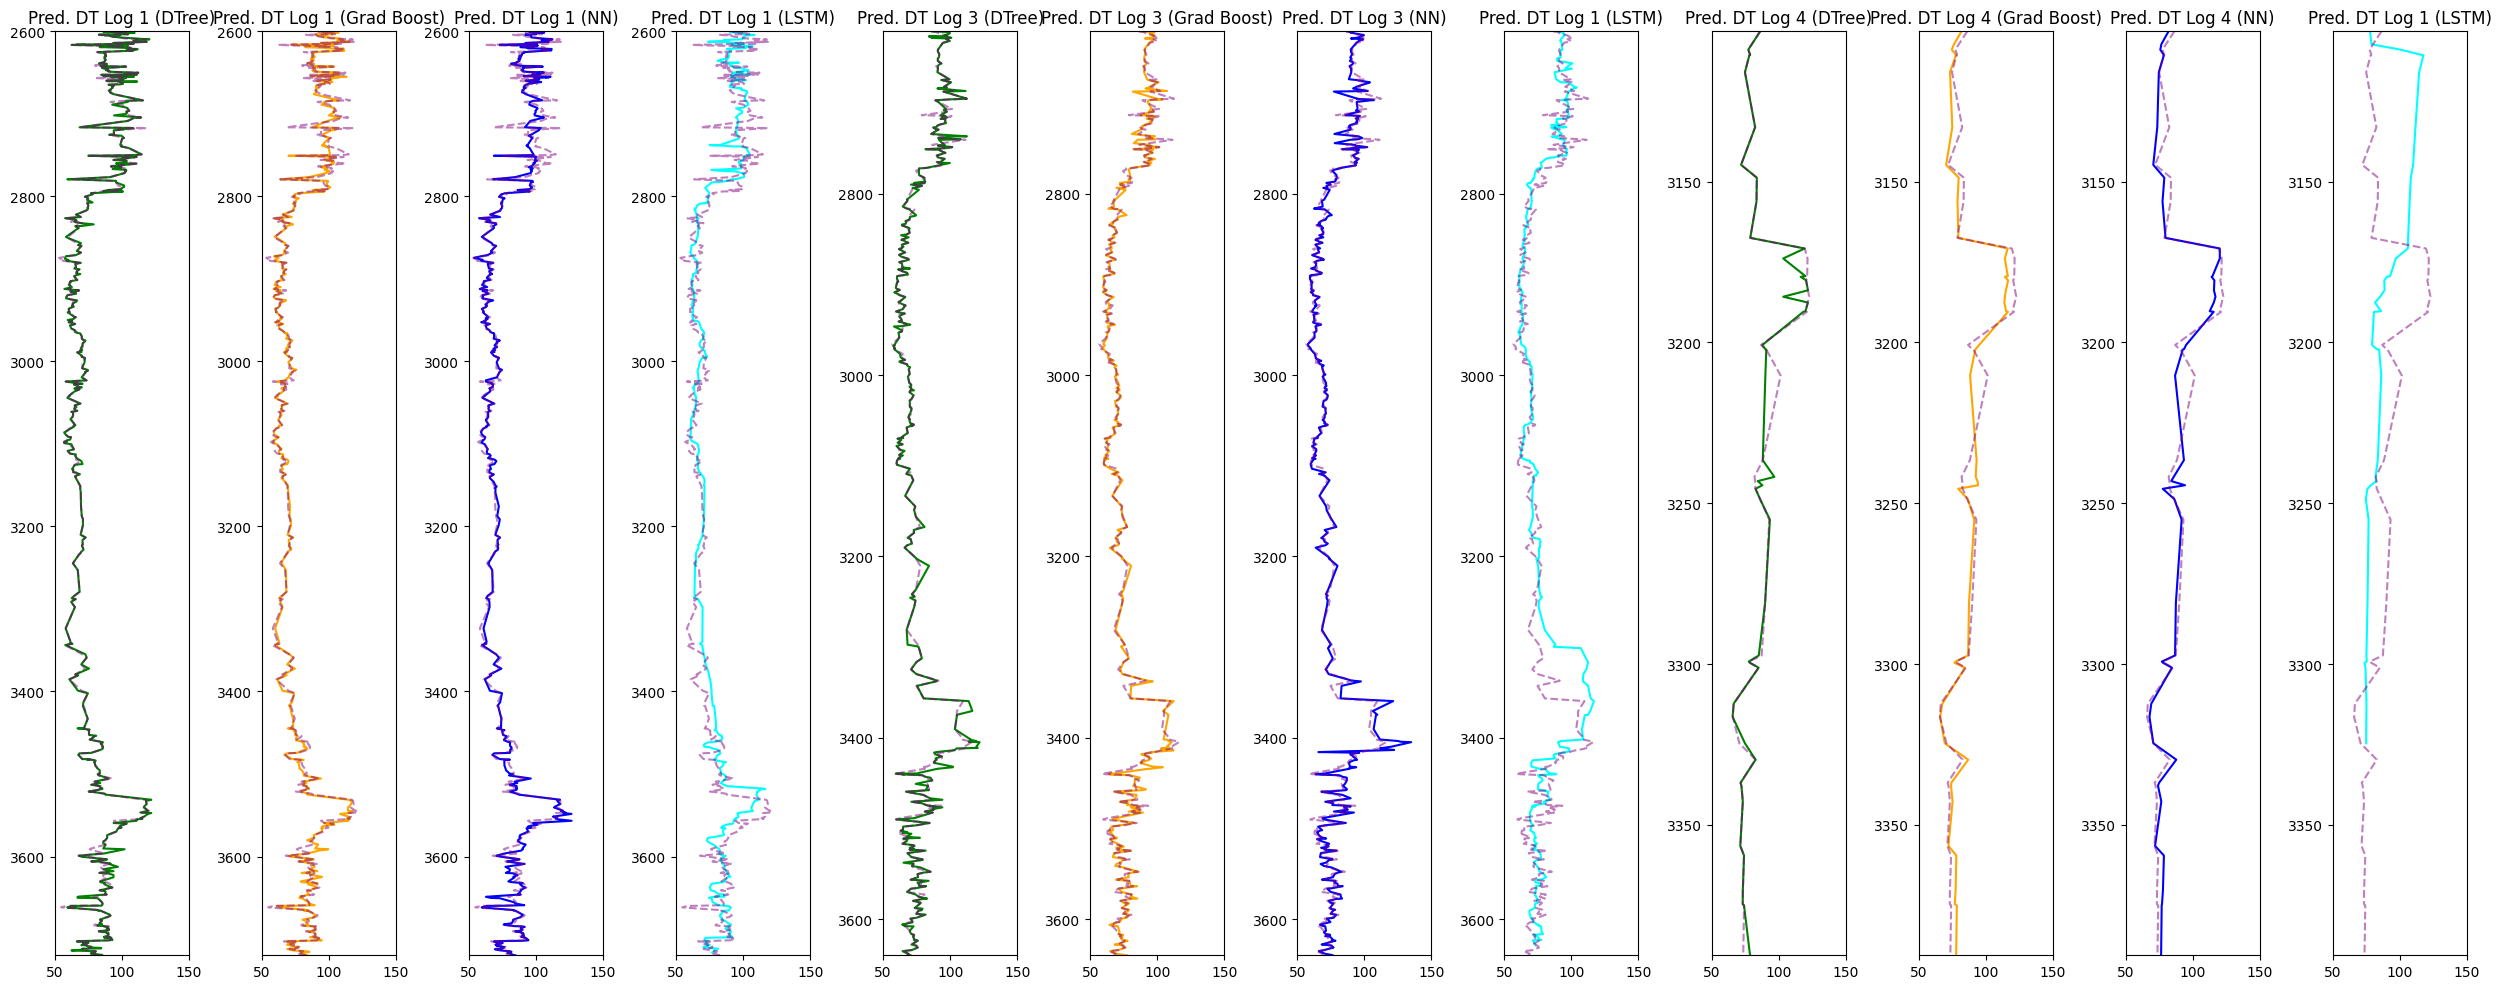

In [22]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott = [train_preserve[train_preserve['WELL'] == '15_9-F-11A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1B']['DEPTH']]
# [log1['DEPTH'],
#            log3['DEPTH'],
#            log4['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [23]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [24]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [25]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 3s 11ms/step


In [26]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [27]:
y_pred2_lstm

array([[60.687626],
       [60.683514],
       [60.681595],
       ...,
       [65.140366],
       [65.3602  ],
       [65.60851 ]], dtype=float32)

In [28]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[60.72772364],
       [60.72370455],
       [60.7198764 ],
       ...,
       [65.1403656 ],
       [65.36019897],
       [65.60851288]])

In [29]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-29-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-29-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-29-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

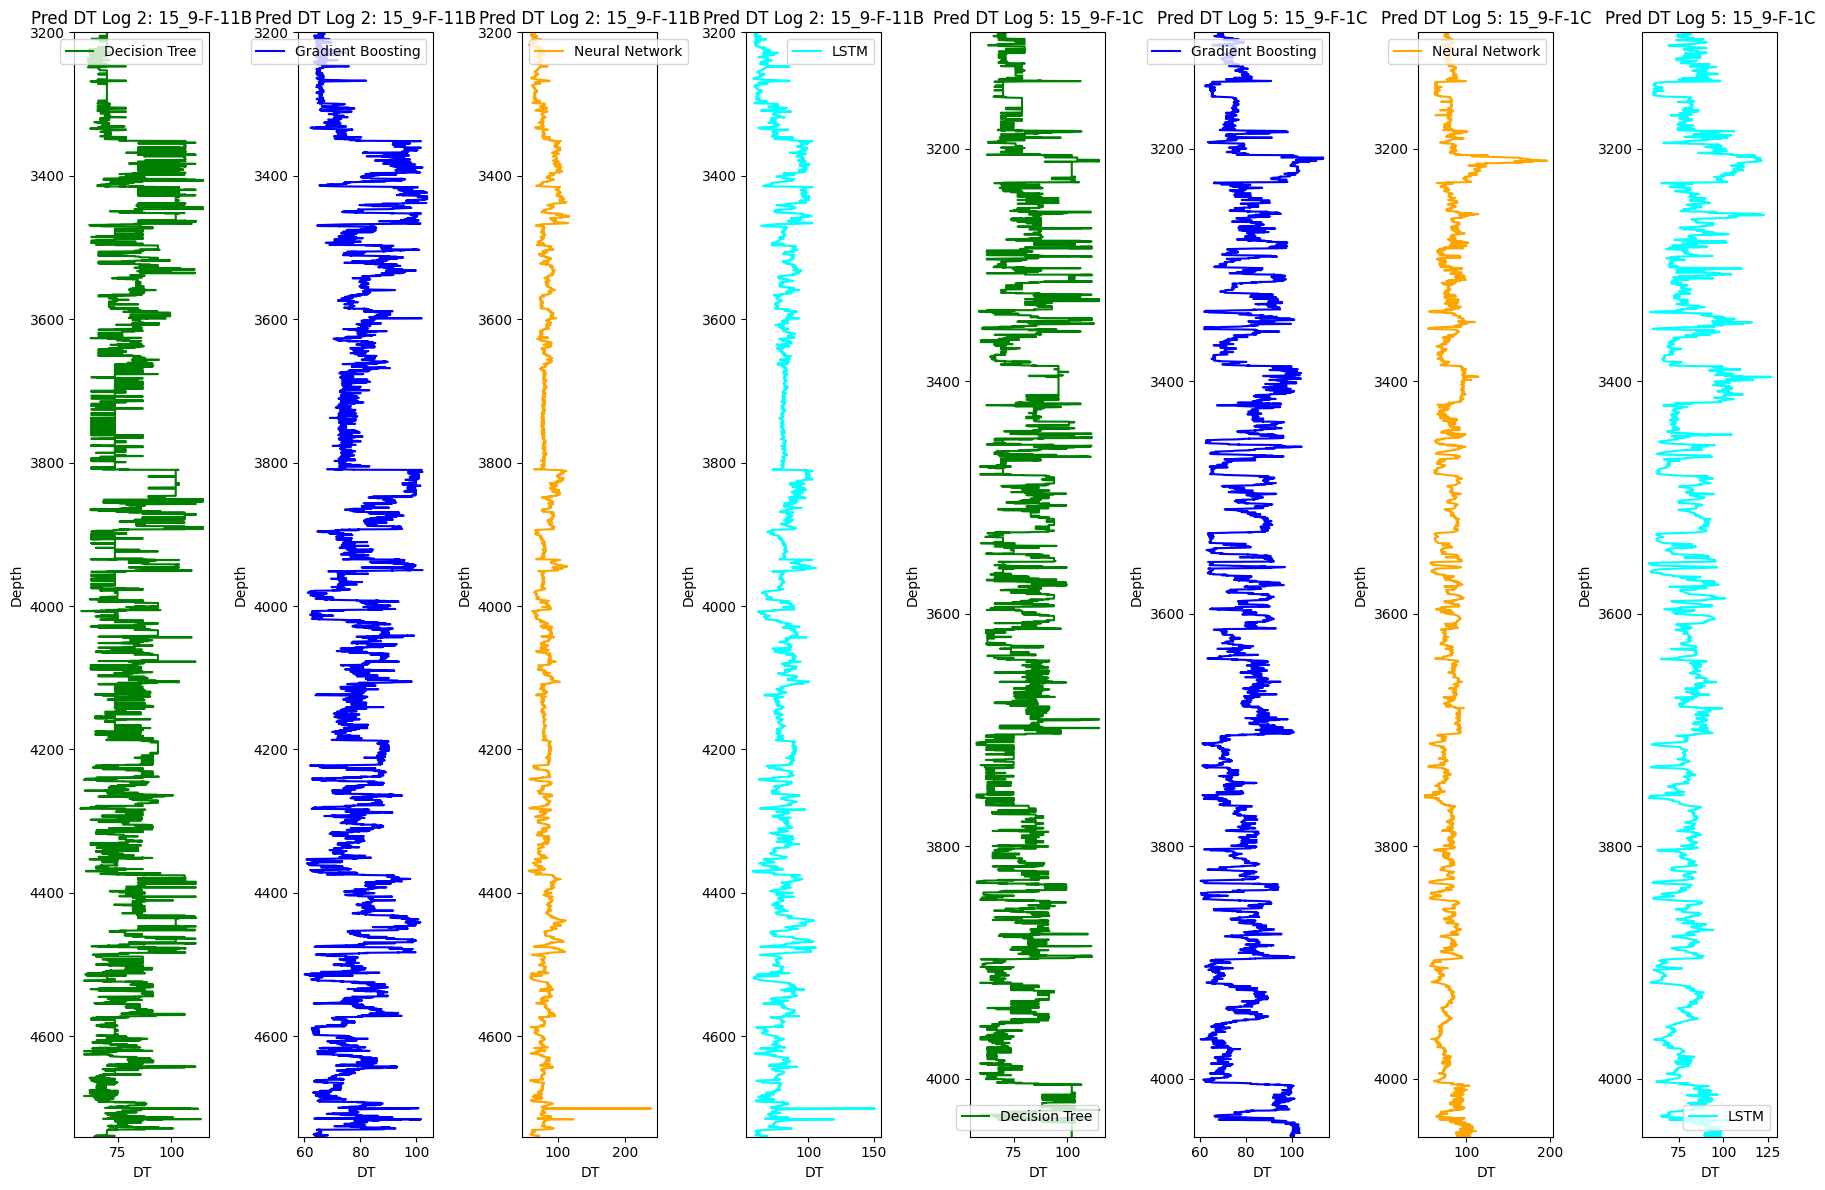

In [30]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='blue', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='orange', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='blue', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='orange', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [31]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

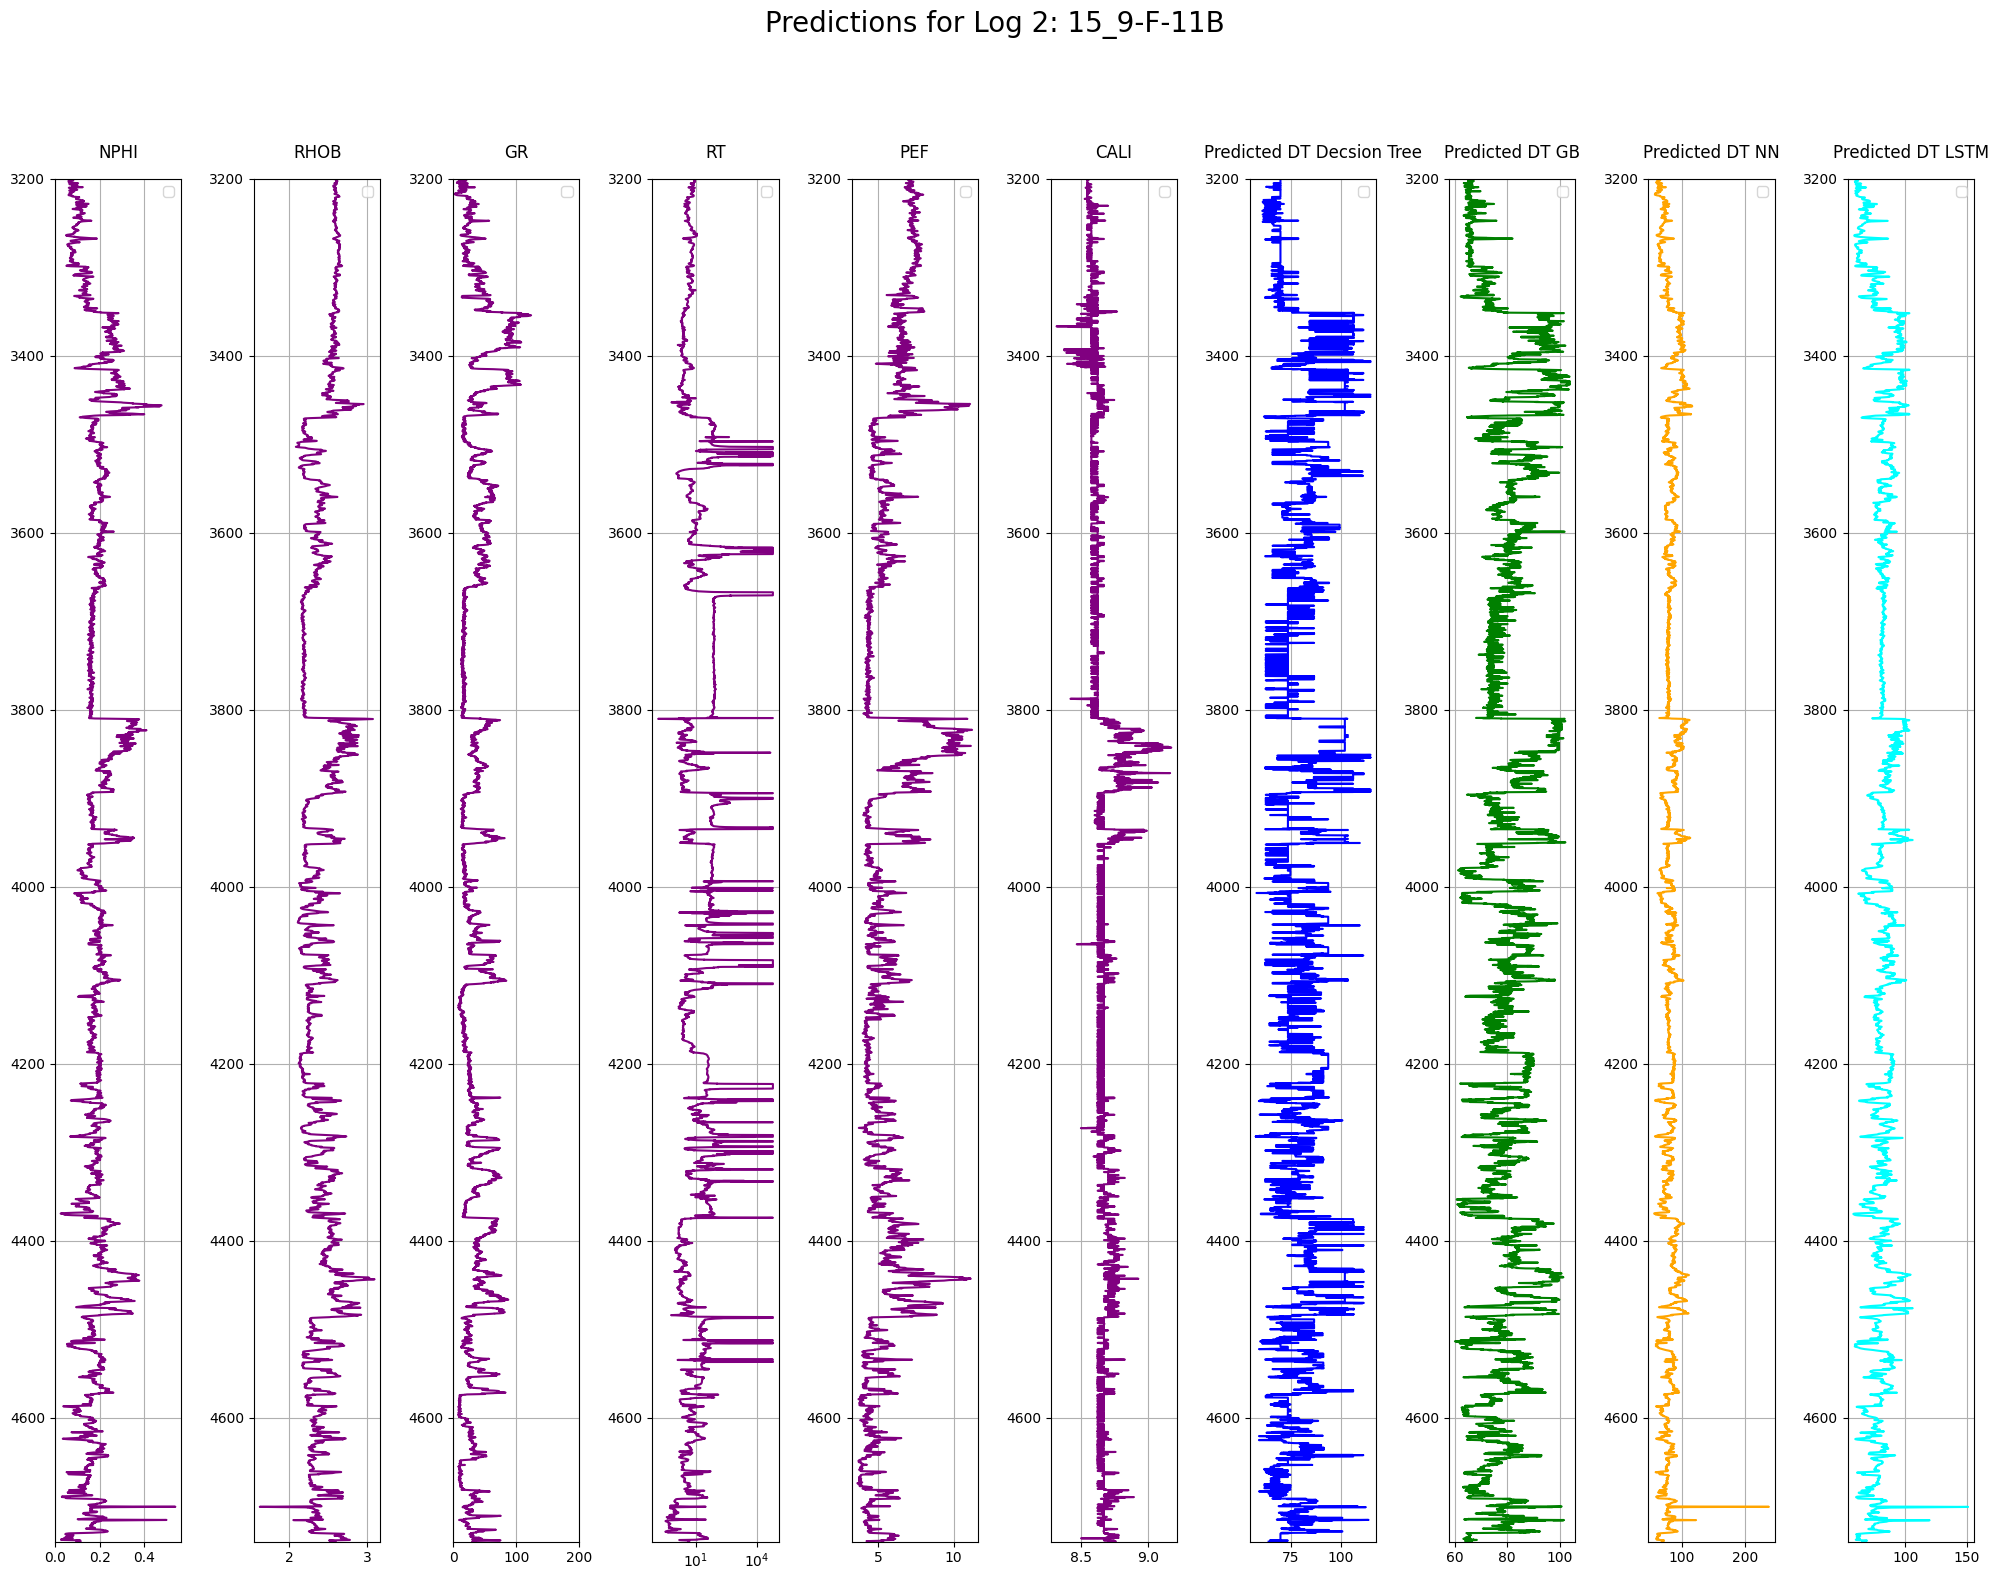

In [32]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue', 'green',  'orange', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

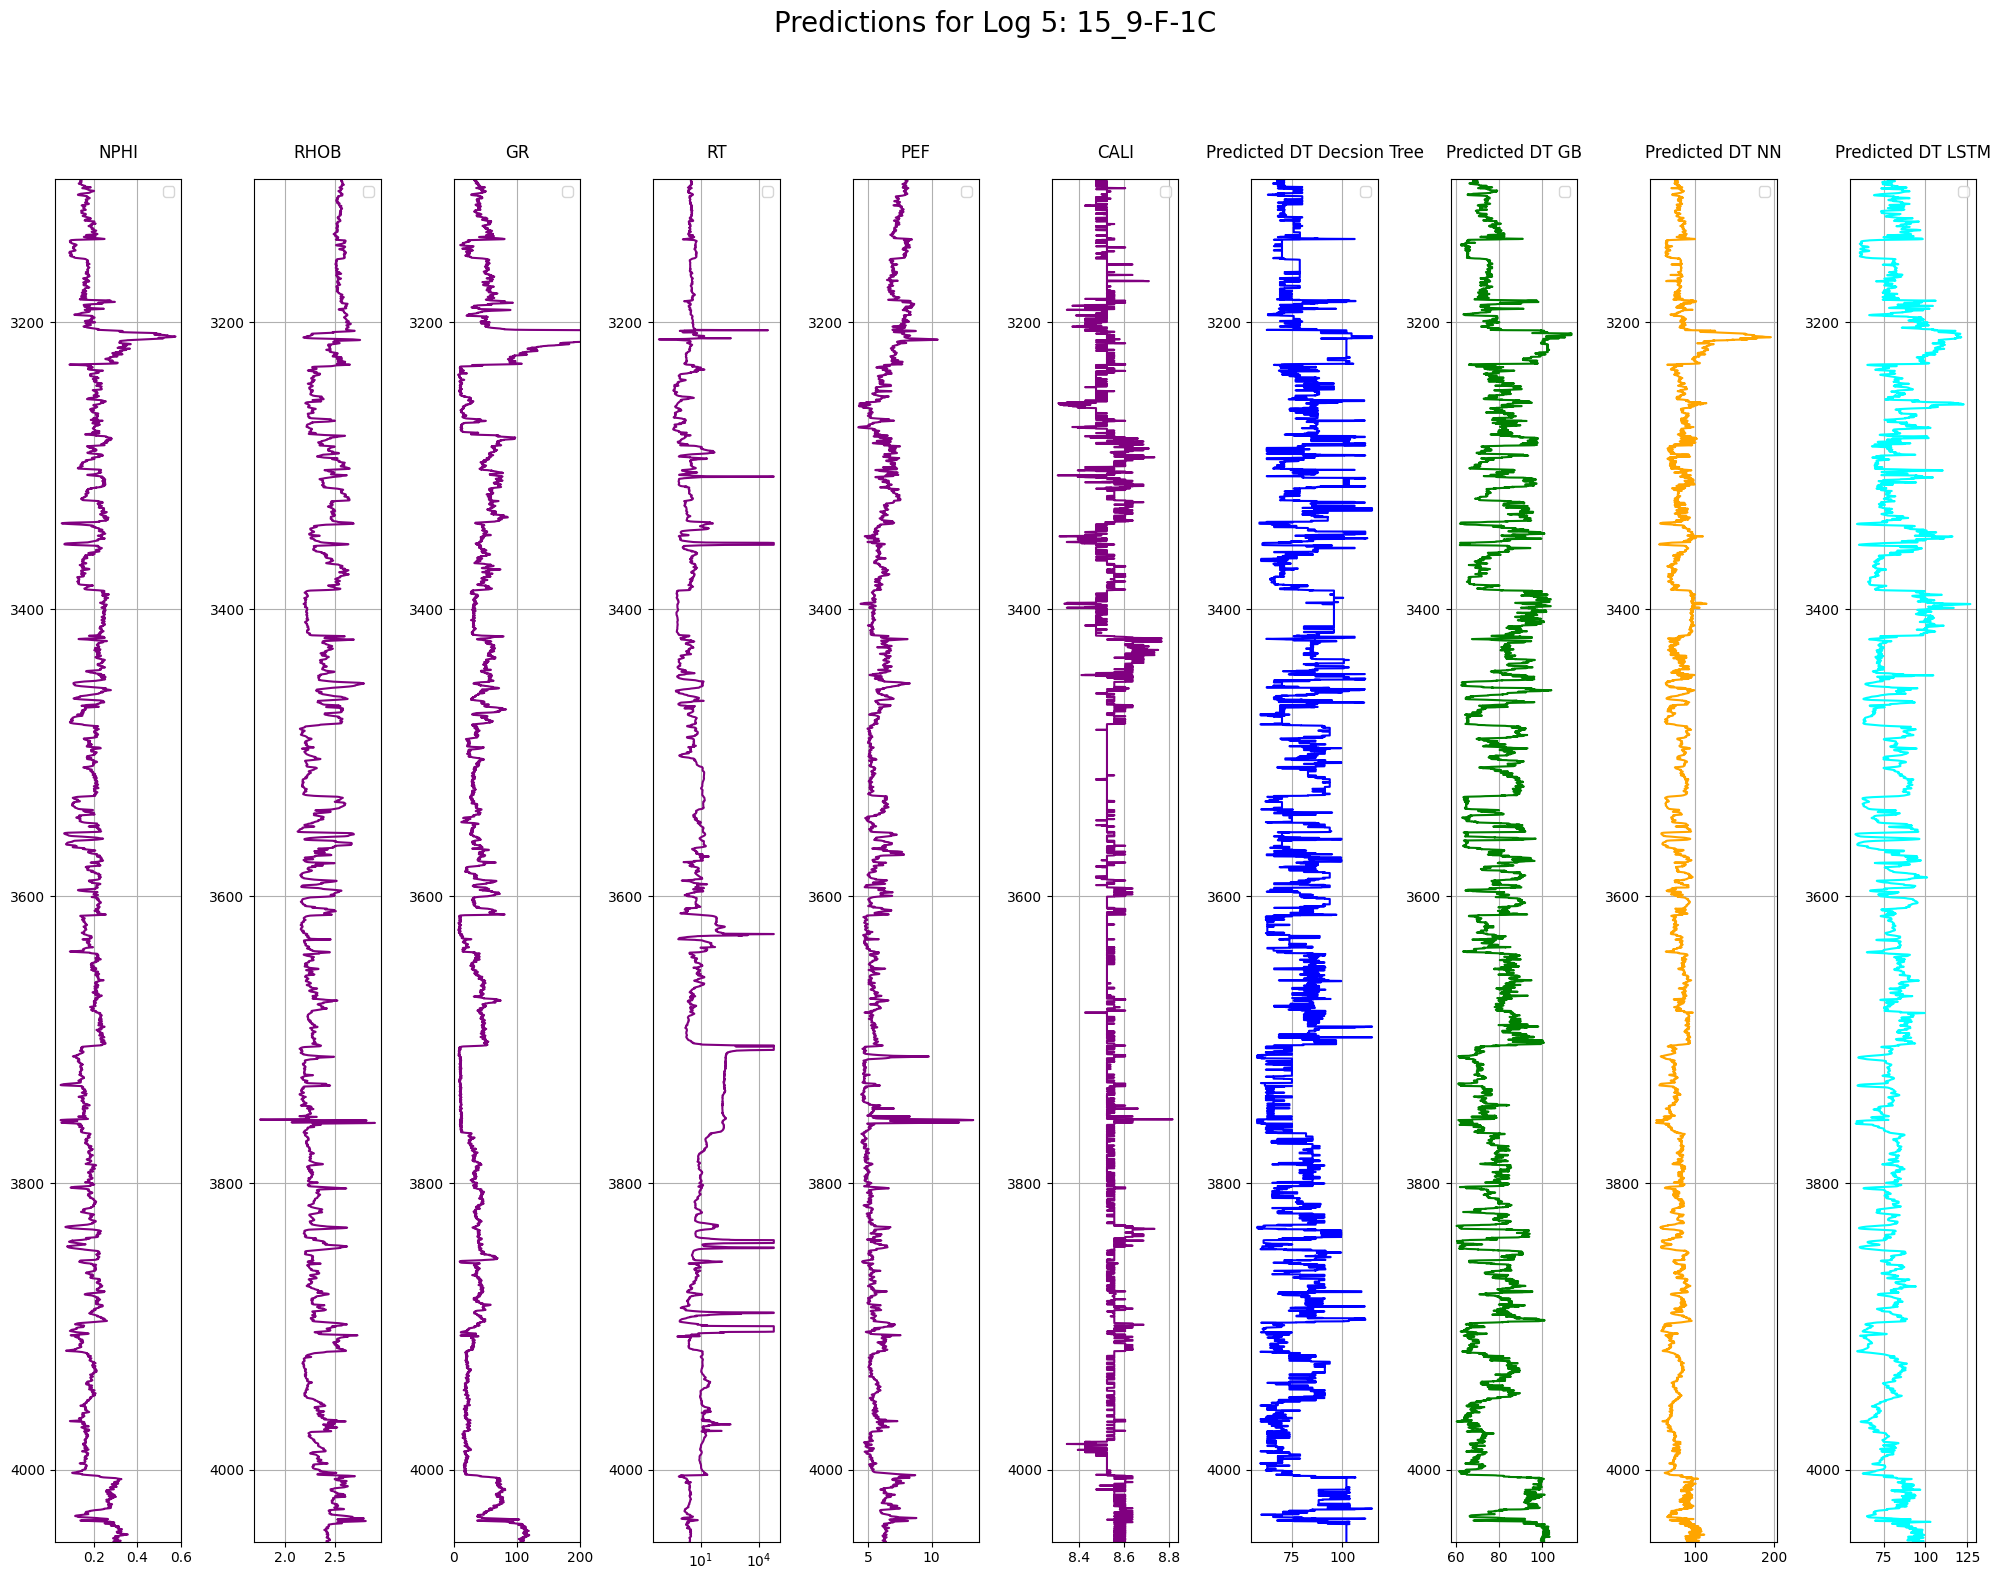

In [33]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple',  'blue',  'green', 'orange', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")